In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
def select_features(X_df, y_series, n_features=1000):
       
    # 3. Select top features based on F-regression
    selector = SelectKBest(score_func=f_regression, k=min(n_features, X_df.shape[1]))
    X_selected = selector.fit_transform(X_df, y_series)
    selected_features = X_df.columns[selector.get_support()].tolist()
    
    return {
        'X_selected': X_df[selected_features],
        'selected_features': selected_features}

In [21]:
def elastic_net_pipeline(X_df, y_series, test_size=0.2, random_state=2411, n_features=1000, plotting=True):
    """
    Enhanced Elastic Net Regression pipeline with genetic feature selection
    """
    # Feature selection
    selection_results = select_features(X_df, y_series, n_features=n_features)
    X_selected = selection_results['X_selected']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, 
        y_series, 
        test_size=test_size, 
        random_state=random_state
    )
    
   
    # Define parameter grid for GridSearchCV
    param_grid = {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
        'l1_ratio': [0.2, 0.3, 0.5, 0.7, 0.9],
    }
    
    # Initialize Elastic Net model
    elastic_net = ElasticNet(max_iter=10000, random_state=random_state)
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(
        elastic_net,
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    
    # Make predictions
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'Feature': X_selected.columns,
        'Coefficient': np.abs(best_model.coef_)
    }).sort_values('Coefficient', ascending=False)
    
    # Plotting
    if plotting:
        fig = plt.figure(figsize=(15, 10))
        
        # Plot 1: Actual vs Predicted
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, y_pred_test, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Test Set: Actual vs Predicted')
        
        # Plot 3: Feature Importance
        plt.subplot(1, 2, 2)
        sns.barplot(data=feature_importance.head(10), x='Coefficient', y='Feature')
        plt.title('Top 10 Most Important Features')
        plt.tight_layout()
    
    return {
        'model': best_model,
        'best_params': grid_search.best_params_,
        'feature_importance': feature_importance,
        'selection_results': selection_results,
        'train_predictions': y_pred_train,
        'test_predictions': y_pred_test,
        'metrics': {
            'train_mse': train_mse,
            'test_mse': test_mse,
            'train_r2': train_r2,
            'test_r2': test_r2
        }
    }

/home/mikhail/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.010e+00, tolerance: 6.498e-01
  model = cd_fast.enet_coordinate_descent(
/home/mikhail/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.474e-01, tolerance: 5.140e-01
  model = cd_fast.enet_coordinate_descent(
/home/mikhail/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Best parameters: {'alpha': 0.01, 'l1_ratio': 0.2}

Model Performance:
Training MSE: 0.0073
Test MSE: 18.9547
Training R²: 0.9999
Test R²: 0.7298

Top 10 most important SNPs:
                    Feature  Coefficient
280  6:15654737:ACCC-ACC:x2     1.028066
487       9:48833950:G-T:x1     1.010299
548        2:8345298:A-C:x2     0.924610
485       9:40219593:A-C:x1     0.904966
118      15:24175321:G-A:x2     0.884710
2         1:42561903:C-T:x2     0.789306
33        4:24745625:C-A:x1     0.760534
210      13:32200499:T-C:x2     0.715230
552        4:9766946:T-C:x1     0.678044
121      15:50428850:T-C:x1     0.675632


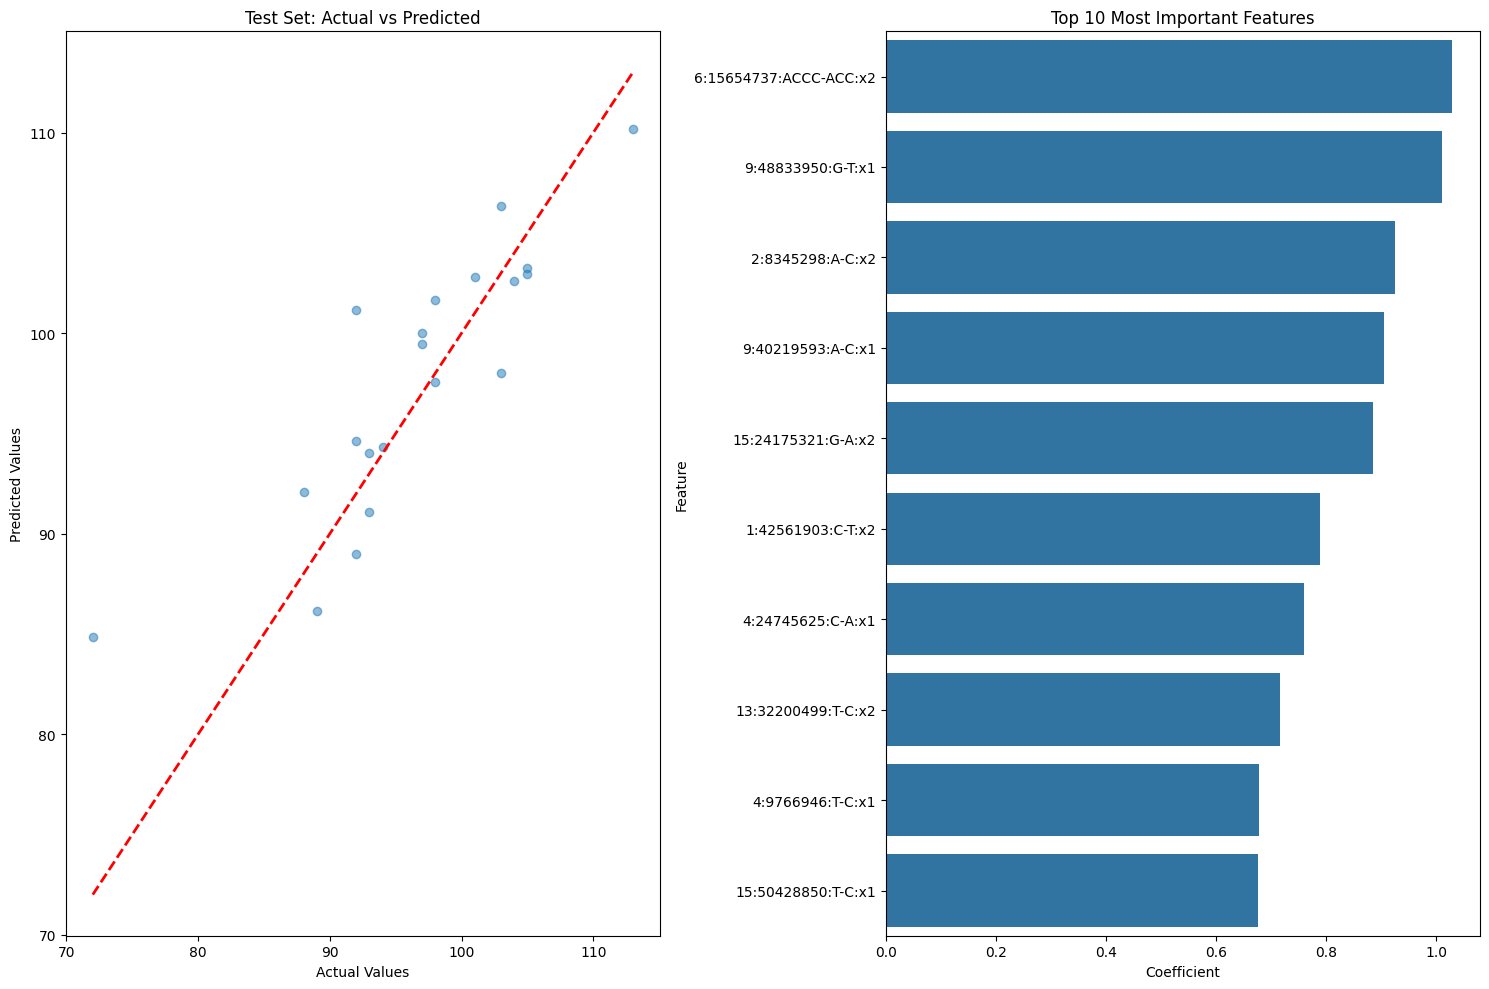

In [17]:
X_df = pd.read_csv('filtered_x1x2_wo_copies.tsv', sep='\t', index_col=0)
phenotypes = pd.read_csv('phenotypes_adjusted.tsv', sep='\t', index_col=0)

results = elastic_net_pipeline(X_df, phenotypes['2016'], n_features=1000)
# Access the results
print("Best parameters:", results['best_params'])
print("\nModel Performance:")
print(f"Training MSE: {results['metrics']['train_mse']:.4f}")
print(f"Test MSE: {results['metrics']['test_mse']:.4f}")
print(f"Training R²: {results['metrics']['train_r2']:.4f}")
print(f"Test R²: {results['metrics']['test_r2']:.4f}")

# View selected features and their importance
print("\nTop 10 most important SNPs:")
print(results['feature_importance'].head(10))

In [6]:
results = {}
mut_importance = {}
for year in phenotypes.columns:
    results[year] = elastic_net_pipeline(X_df, phenotypes[year], n_features=1000, plotting=False)

/home/mikhail/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.864e+00, tolerance: 1.369e+00
  model = cd_fast.enet_coordinate_descent(
/home/mikhail/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.618e+00, tolerance: 1.738e+00
  model = cd_fast.enet_coordinate_descent(
/home/mikhail/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

In [7]:
results['2017']['feature_importance']

,Feature,Coefficient
270,11:1652691:A-G:x2,0.925076
138,15:7712339:T-G:x2,0.817517
238,3:28934833:T-C:x1,0.811940
744,6:37253284:C-T:x1,0.801705
266,9:38504766:A-G:x2,0.751765
...,...,...
109,9:43427346:T-G:x2,0.000000
110,9:43428275:G-A:x2,0.000000
111,9:43428289:G-C:x2,0.000000
625,4:41744114:C-T:x2,0.000000


In [8]:
aggregared_coefs = {}
for year in results.keys():
    df = results[year]['feature_importance'].head(100)
    for index, row in df.iterrows():
        try:
            aggregared_coefs[row['Feature']] += row['Coefficient']
        except KeyError:
            aggregared_coefs[row['Feature']] = row['Coefficient']

In [9]:
aggregared_coefs

{'18:50590052:TAAAAAAAAAAAAA-TAAAAAAAAAAA:x1': 1.0042351820804845,
 '19:26426264:A-G:x1': 0.9855275917078822,
 '13:7358408:A-G:x1': 0.847776335900733,
 '8:44091353:CTAT-CTATAT:x1': 0.8397225458247993,
 '10:6245038:TATAGAGAGA-TAGAGA:x1': 0.8198970654094461,
 '10:27612109:T-C:x1': 0.7802224836924121,
 '9:13905377:C-T:x2': 0.7603084522326311,
 '17:23594823:T-C:x1': 1.0970643371051456,
 '10:39439141:TGTTTTTTG-T:x1': 0.7480335370701974,
 '5:3358358:G-A:x1': 0.7086109648495253,
 '13:35824748:GTCTTCTTCTTCTTCTTCT-GTCTTCTTCTTCTTCT:x1': 0.6866974582693423,
 '2:8976327:T-C:x1': 0.685965177757225,
 '16:5558180:T-C:x1': 0.6831401830782152,
 '8:44091355:ATTTTTTTTTT-ATTTTTTTTTTTT:x2': 0.6749934856528261,
 '20:17593116:A-G:x2': 0.6665686663716089,
 '18:18978583:A-G:x2': 0.6632363589020311,
 '16:27013788:T-A:x2': 0.6412372236302869,
 '17:509965:C-T:x1': 0.6271685022697698,
 '13:17091658:T-C:x2': 0.6268344697241961,
 '18:34600858:C-T:x1': 1.255114000028203,
 '19:35190032:GTCTTCTTCTT-GTCTTCTT:x2': 0.6061

In [10]:
best_features = {k: v for k, v in sorted(aggregared_coefs.items(), key=lambda item: -1*item[1])[:20]}

In [11]:
best_features

{'14:46675012:A-C:x2': 3.569301380133406,
 '15:9214204:ACC-AC:x2': 3.451395497225321,
 '13:38328759:C-A:x2': 2.7518789902686454,
 '4:25950254:G-T:x2': 2.6528168931752267,
 '10:39439126:ATGTTTTTTGTTTTTTGTTTTTTGTTTTTT-ATGTTTTTTGTTTTTTGTTTTTT:x1': 2.5075100532624437,
 '5:21256935:G-A:x1': 2.4037782075681,
 '15:2745830:TTT-TTTTAAAAAAAAAAAATT:x2': 2.3411824854260566,
 '2:47215398:GAA-G:x2': 2.340073900591322,
 '2:2423885:G-A:x1': 2.202866755973534,
 '1:44224913:G-A:x2': 2.146857547560527,
 '4:49116115:GCCACCACCACCACCACCACC-GCCACCACCACCACCACC:x1': 2.075438179610751,
 '14:3559296:A-G:x1': 1.9622575802407738,
 '5:37283100:G-A:x2': 1.91975156582503,
 '4:8039183:A-G:x1': 1.8876927628683773,
 '10:259448:A-T:x2': 1.7816376115157018,
 '4:25714113:G-A:x1': 1.7533957542380254,
 '10:33390880:G-A:x2': 1.7512323152081157,
 '6:19611201:T-C:x2': 1.7361950109944688,
 '1:42463100:C-T:x2': 1.7357037306751086,
 '14:46675129:T-C:x2': 1.6812758528925595}

In [12]:
list(best_features.keys())

['14:46675012:A-C:x2',
 '15:9214204:ACC-AC:x2',
 '13:38328759:C-A:x2',
 '4:25950254:G-T:x2',
 '10:39439126:ATGTTTTTTGTTTTTTGTTTTTTGTTTTTT-ATGTTTTTTGTTTTTTGTTTTTT:x1',
 '5:21256935:G-A:x1',
 '15:2745830:TTT-TTTTAAAAAAAAAAAATT:x2',
 '2:47215398:GAA-G:x2',
 '2:2423885:G-A:x1',
 '1:44224913:G-A:x2',
 '4:49116115:GCCACCACCACCACCACCACC-GCCACCACCACCACCACC:x1',
 '14:3559296:A-G:x1',
 '5:37283100:G-A:x2',
 '4:8039183:A-G:x1',
 '10:259448:A-T:x2',
 '4:25714113:G-A:x1',
 '10:33390880:G-A:x2',
 '6:19611201:T-C:x2',
 '1:42463100:C-T:x2',
 '14:46675129:T-C:x2']

In [13]:
best_features = {k: v for k, v in sorted(aggregared_coefs.items(), key=lambda item: -1*item[1])[:30]}

In [15]:
X_df[best_features.keys()].to_csv('30_best_features_01.tsv', sep='\t', index=True)

In [30]:
results['2016']['feature_importance']

,Feature,Coefficient
280,6:15654737:ACCC-ACC:x2,1.042956
487,9:48833950:G-T:x1,0.971356
118,15:24175321:G-A:x2,0.938593
548,2:8345298:A-C:x2,0.936085
485,9:40219593:A-C:x1,0.920122
...,...,...
618,8:3846101:C-T:x2,0.000000
613,17:40275100:A-C:x2,0.000000
612,14:1744518:C-A:x2,0.000000
611,14:1710287:C-A:x1,0.000000


In [43]:
desc_df = pd.DataFrame()
for year in results:
    importance = results[year]['feature_importance']
    importance = importance.set_index('Feature')
    importance = importance[importance['Coefficient']!=0]
    desc_df[year] = importance['Coefficient'].describe()

In [45]:
desc_df.to_csv('Mut_description.tsv', sep='\t', index=True)

In [12]:
X_df = pd.read_csv('filtered_x1x2_wo_copies.tsv', sep='\t', index_col=0)
target = pd.read_csv('target_df.tsv', sep='\t', index_col=0)

In [19]:
target

,sum_temp,mean_temp,sum_rain,mean_rain,sum_cloud,mean_cloud,sum_humid,mean_humid,sum_sun,mean_sun
PS000026,2.537319,2.537319,-0.023460,-0.023460,0.783746,0.783746,-2.106912,-2.106912,-0.197144,-0.197144
PS000027,2.118718,2.118718,2.388284,2.388284,2.283415,2.283415,-8.681964,-8.681964,-2.037363,-2.037363
PS000028,1.912452,1.912452,5.111621,5.111621,-0.365763,-0.365763,-4.783960,-4.783960,-1.587039,-1.587039
PS000031,-0.154924,-0.154924,2.157594,2.157594,0.882981,0.882981,-5.725506,-5.725506,-1.270262,-1.270262
PS000033,3.516477,3.516477,3.000659,3.000659,1.412185,1.412185,-0.064538,-0.064538,-2.257386,-2.257386
...,...,...,...,...,...,...,...,...,...,...
PS000444,1.274560,1.274560,2.546026,2.546026,-0.403850,-0.403850,-0.768526,-0.768526,-0.723351,-0.723351
PS000566,-0.067503,-0.067503,1.121828,1.121828,-0.469060,-0.469060,0.720050,0.720050,-0.236103,-0.236103
PS000567,-2.583769,-2.583769,-0.100628,-0.100628,-1.500731,-1.500731,1.769986,1.769986,0.859657,0.859657
PS000568,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Best parameters: {'alpha': 0.001, 'l1_ratio': 0.2}

Model Performance:
Training MSE: 0.0000
Test MSE: 2.1230
Training R²: 1.0000
Test R²: 0.4083

Top 10 most important SNPs:
                                    Feature  Coefficient
179                      12:35174802:C-T:x2     0.333616
251  11:5943658:GTTTTTTTTTT-GTTTTTTTTTTT:x1     0.330002
70                       13:44012729:T-G:x1     0.325979
809                       3:28942573:A-G:x1     0.325407
710                       11:8058408:T-C:x1     0.323173
612                       5:18332837:A-G:x1     0.310321
134                       3:38157995:G-A:x2     0.301927
17           2:44475749:GCGAGCACCACAC-GC:x2     0.296840
601                      10:16899142:T-C:x1     0.295991
581                        17:510168:A-G:x2     0.287459


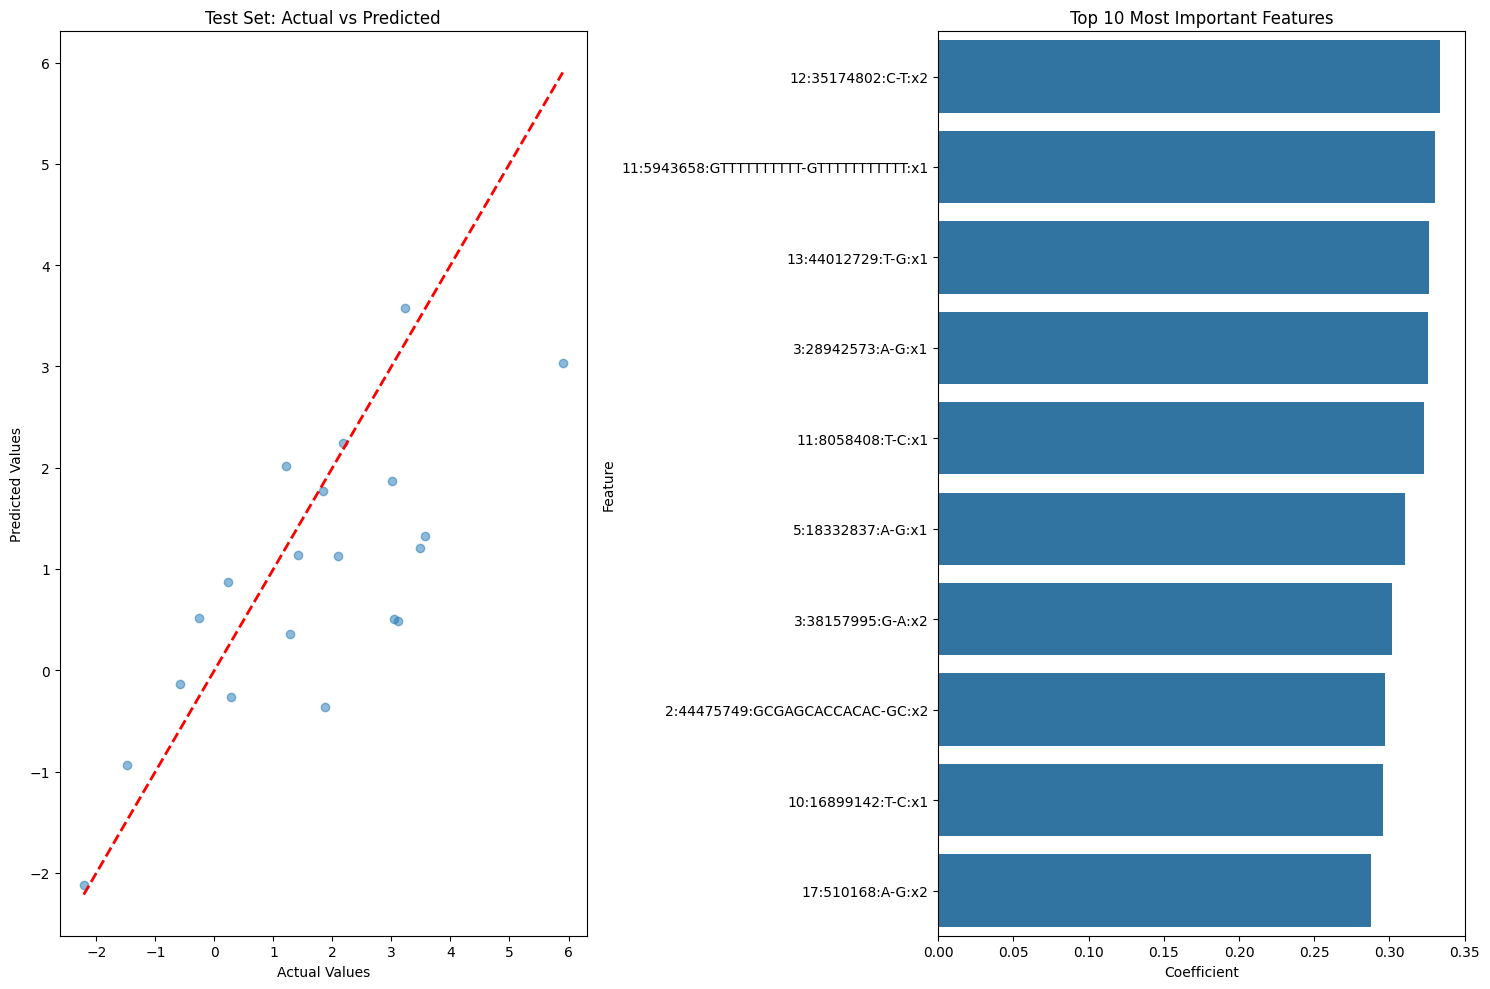

In [23]:
X_df = pd.read_csv('filtered_x1x2_wo_copies.tsv', sep='\t', index_col=0)
phenotypes = pd.read_csv('phenotypes_adjusted.tsv', sep='\t', index_col=0)

results = elastic_net_pipeline(X_df, target['sum_rain'], n_features=1000)
# Access the results
print("Best parameters:", results['best_params'])
print("\nModel Performance:")
print(f"Training MSE: {results['metrics']['train_mse']:.4f}")
print(f"Test MSE: {results['metrics']['test_mse']:.4f}")
print(f"Training R²: {results['metrics']['train_r2']:.4f}")
print(f"Test R²: {results['metrics']['test_r2']:.4f}")

# View selected features and their importance
print("\nTop 10 most important SNPs:")
print(results['feature_importance'].head(10))